Detected raw SWE data for Center Ridge SNOTEL — computing DATE-AWARE net storm totals...
 → Using TRUE net gain (SWE_today - SWE_n-days-ago).clip(0)
 → Fully respects gaps — operationally correct
Storm totals exported → Center_Ridge_SNOTEL_Storm_Totals_1982-2025.csv
CENTER RIDGE SNOTEL — DATASET SUMMARY
Date range : 1982-10-01 → 2025-09-16
Total calendar days : 15,692

Period    Missing  Negative         Zero  Storm days (>0)
-----------------------------------------------------------------
1-day           0         0       11,467            4,225
3-day           0         0        9,607            6,085
7-day           0         0        8,251            7,441
10-day          0         0        7,816            7,876
-----------------------------------------------------------------
Note: All plots below use ONLY storm days (>0" SWE)


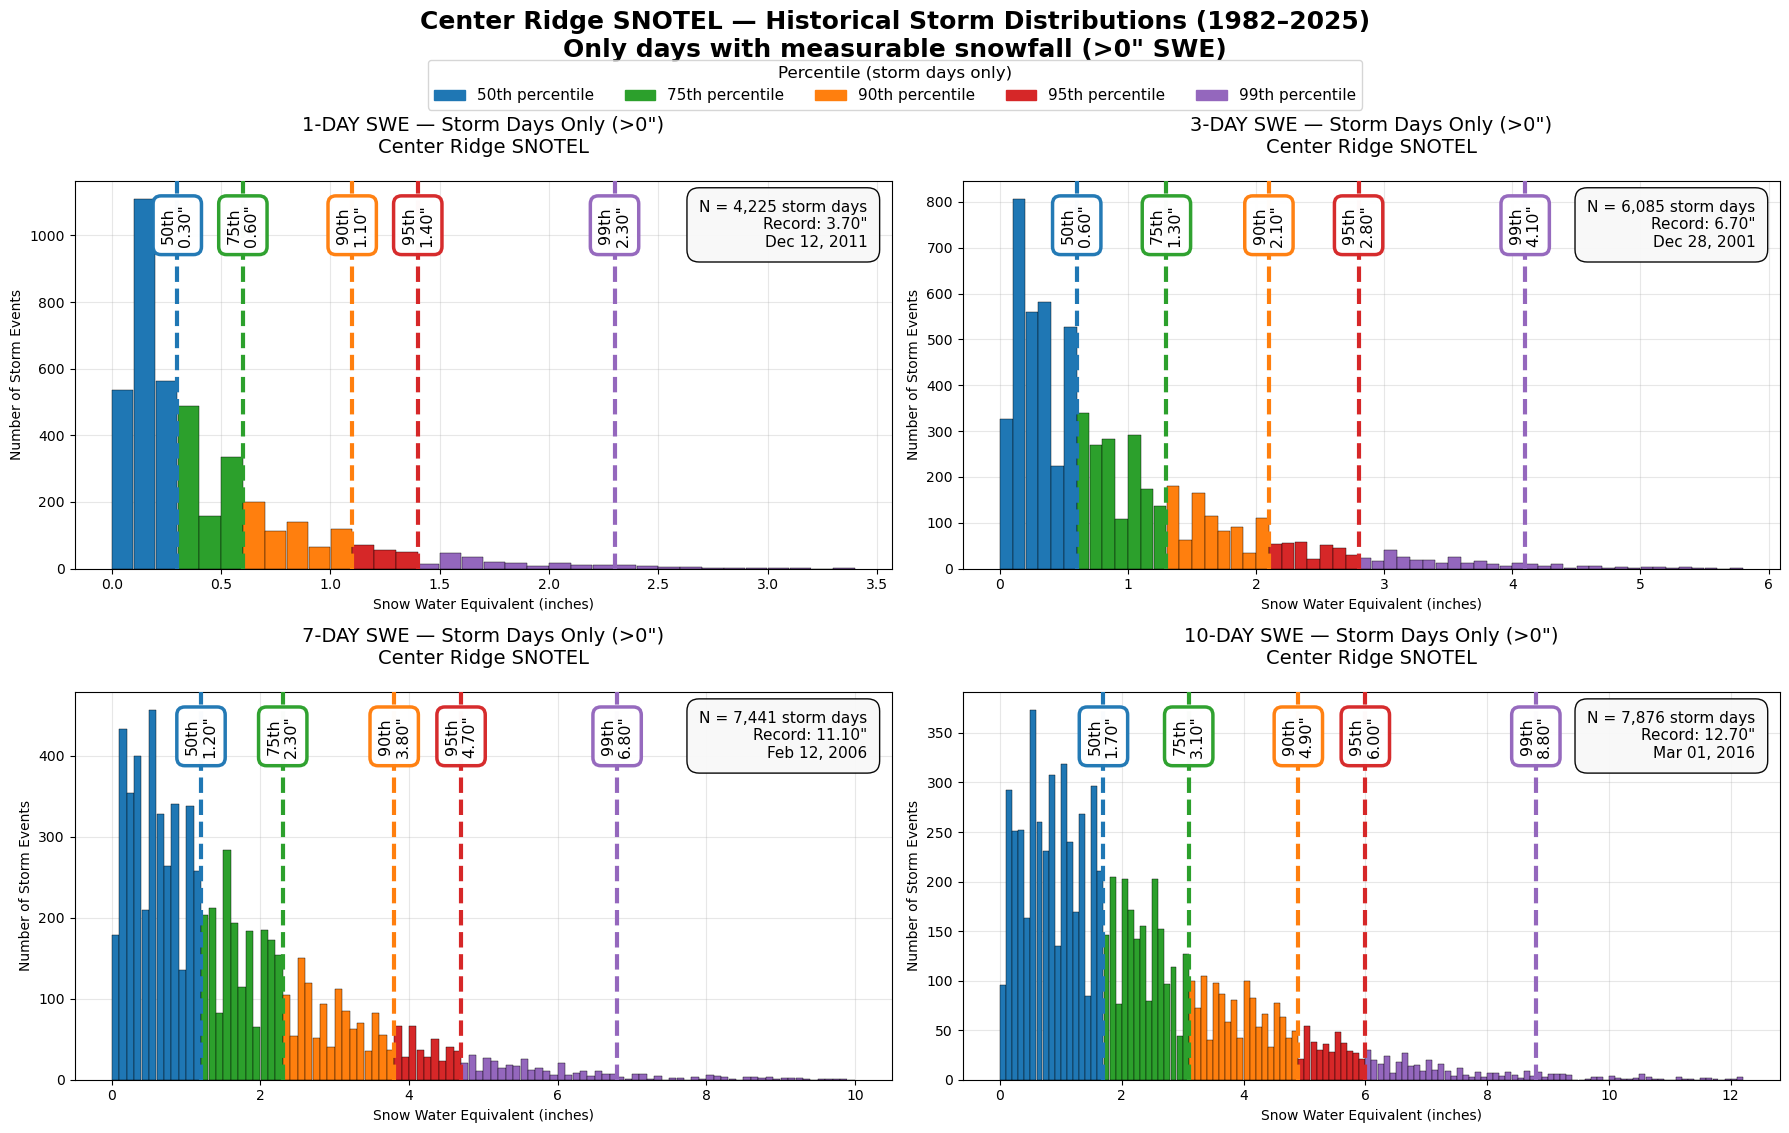

Plot saved → Center_Ridge_SNOTEL_StormTracker_MultiColor_2025-11-25.png


In [18]:
# This version automatically calculates 1, 3, 7, 10 day SWE from raw NRCS SNOTEL SWE data (date, SWE total)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ================================================================
# CHANGE THESE FOR EACH STATION
# ================================================================
STATION_NAME = "Center Ridge SNOTEL"  # ← Change this!
CSV_PATH = "/home/sykes-sfu/Documents/CNFAIC/Storm Tracker/Center Ridge - Turnagain Pass NRCSdata.csv"

# TOGGLE FOR TESTING — SET TO True TO SEE CLEAN SINGLE-COLOR HISTOGRAM
SINGLE_COLOR_MODE = False
# ================================================================

# -------------------------------
# LOAD AND CLEAN
# -------------------------------
if 'NRCSdata' in CSV_PATH or CSV_PATH.endswith('.csv'):
    df = pd.read_csv(CSV_PATH, header=None, names=['Date', 'SWE'])
else:
    df = pd.read_csv(CSV_PATH)

df.replace(['', '#NA', '#VALUE!', 'NA'], np.nan, inplace=True)
for col in df.columns:
    if col != 'Date':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).copy()

# -------------------------------
# AUTO-COMPUTE STORM TOTALS — TRUE NET GAIN (Gold Standard)
# -------------------------------
if 'SWE' in df.columns and 'delta_SWE' not in df.columns:
    print(f"Detected raw SWE data for {STATION_NAME} — computing DATE-AWARE net storm totals...")
    df = df.sort_values('Date').reset_index(drop=True)
    
    df['SWE_clean'] = df['SWE'].ffill()
    df = df.set_index('Date')
    
    df['delta_SWE'] = (df['SWE_clean'] - df['SWE_clean'].shift(1)).clip(lower=0)
    df['3-day']     = (df['SWE_clean'] - df['SWE_clean'].shift(3)).clip(lower=0)
    df['7-day']     = (df['SWE_clean'] - df['SWE_clean'].shift(7)).clip(lower=0)
    df['10-day']    = (df['SWE_clean'] - df['SWE_clean'].shift(10)).clip(lower=0)
    
    df[['delta_SWE','3-day','7-day','10-day']] = df[['delta_SWE','3-day','7-day','10-day']].fillna(0)
    df = df.drop(columns=['SWE_clean']).reset_index()

    print(" → Using TRUE net gain (SWE_today - SWE_n-days-ago).clip(0)")
    print(" → Fully respects gaps — operationally correct")

# -------------------------------
# EXPORT STORM TOTALS TO CSV
# -------------------------------
start_year = df['Date'].dt.year.min()
end_year   = df['Date'].dt.year.max()
export_df = df[['Date', 'delta_SWE', '3-day', '7-day', '10-day']].copy()
export_df['Date'] = export_df['Date'].dt.strftime('%Y-%m-%d')
safe_name = STATION_NAME.replace(" ", "_")
export_filename = f"{safe_name}_Storm_Totals_{start_year}-{end_year}.csv"
export_df.to_csv(export_filename, index=False)
print(f"Storm totals exported → {export_filename}")

# -------------------------------
# DATASET SUMMARY
# -------------------------------
print("="*90)
print(f"{STATION_NAME.upper()} — DATASET SUMMARY")
print("="*90)
print(f"Date range : {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Total calendar days : {len(df):,}")
print()

columns = {'1-day': 'delta_SWE', '3-day': '3-day', '7-day': '7-day', '10-day': '10-day'}
print(f"{'Period':<8} {'Missing':>8} {'Negative':>9} {'Zero':>12} {'Storm days (>0)':>16}")
print("-" * 65)
for period, col in columns.items():
    miss = df[col].isna().sum()
    neg  = (df[col] < 0).sum()
    zero = (df[col] == 0).sum()
    pos  = (df[col] > 0).sum()
    print(f"{period:<8} {miss:8,} {neg:9,} {zero:12,} {pos:16,}")
print("-" * 65)
print("Note: All plots below use ONLY storm days (>0\" SWE)")
print("="*90)

# -------------------------------
# PLOT
# -------------------------------
bins_per_inch = 10
rwidth = 0.98
edge_lw = 0.3
percentiles = [50, 75, 90, 95, 99]
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

legend_patches = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
legend_labels  = [f'{p}th percentile' for p in percentiles]

for idx, (period, col) in enumerate(columns.items()):
    ax = axes[idx]
    storm = df[[col, 'Date']].dropna()
    storm = storm[storm[col] > 0].copy()
    values = storm[col]
    
    if len(values) < 50:
        ax.text(0.5, 0.5, 'Insufficient data', transform=ax.transAxes, ha='center', fontsize=14)
        continue
    
    p_vals = np.percentile(values, percentiles)
    record_val = values.max()
    record_date = storm.loc[values.idxmax(), 'Date'].strftime('%b %d, %Y')
    n_storms = len(values)
    
    max_plot = values.quantile(0.9995)
    bin_width = 1.0 / bins_per_inch
    bins = np.arange(0, max_plot + bin_width, bin_width)
    
    if SINGLE_COLOR_MODE:
        # Clean single-color test
        ax.hist(values, bins=bins, rwidth=rwidth,
                color='#1f77b4', edgecolor='black', linewidth=edge_lw, alpha=0.9)
    else:
        # Multi-color percentile version
        counts, edges, patches = ax.hist(values, bins=bins, rwidth=rwidth,
                                         color='lightgray', edgecolor='white', linewidth=0, zorder=2)
        bounds = [0] + list(p_vals) + [values.max() + 0.01]
        segment_colors = colors + ['#9467bd']
        for i, patch in enumerate(patches):
            center = (edges[i] + edges[i+1]) / 2
            for j in range(1, len(bounds)):
                if center < bounds[j]:
                    patch.set_facecolor(segment_colors[j-1])
                    break
            patch.set_edgecolor('black')
            patch.set_linewidth(edge_lw)
    
    # Percentile lines + labels
    for p, val, c in zip(percentiles, p_vals, colors):
        ax.axvline(val, color=c, linestyle='--', linewidth=3, zorder=3)
        ax.text(val, ax.get_ylim()[1] * 0.94,
                f'{p}th\n{val:.2f}"',
                rotation=90, va='top', ha='center', fontsize=11.5,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.98,
                          edgecolor=c, linewidth=2.5), zorder=10)
    
    stats_text = f"N = {n_storms:,} storm days\nRecord: {record_val:.2f}\"\n{record_date}"
    ax.text(0.97, 0.95, stats_text, transform=ax.transAxes, va='top', ha='right', fontsize=11,
            bbox=dict(boxstyle="round,pad=0.8", facecolor="#f8f8f8", alpha=0.97))
    
    ax.set_title(f"{period.upper()} SWE — Storm Days Only (>0\")\n{STATION_NAME}",
                 fontsize=14, pad=20)
    ax.set_xlabel("Snow Water Equivalent (inches)")
    ax.set_ylabel("Number of Storm Events")
    ax.grid(True, alpha=0.3)

# Title
title_text = f'{STATION_NAME}'
if SINGLE_COLOR_MODE:
    title_text += " (Single-Color Test Mode)"
title_text += f' — Historical Storm Distributions ({start_year}–{end_year})\nOnly days with measurable snowfall (>0" SWE)'

fig.suptitle(title_text, fontsize=18, fontweight='bold', y=0.98)

# Legend only in multi-color mode
if not SINGLE_COLOR_MODE:
    fig.legend(legend_patches, legend_labels,
               loc='upper center', bbox_to_anchor=(0.5, 0.945),
               ncol=5, fancybox=True, shadow=False,
               title="Percentile (storm days only)", fontsize=11, title_fontsize=12)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

today = datetime.now().strftime("%Y-%m-%d")
mode = "SingleColor" if SINGLE_COLOR_MODE else "MultiColor"
plot_filename = f'{safe_name}_StormTracker_{mode}_{today}.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Plot saved → {plot_filename}")